In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

https://www.youtube.com/watch?v=hhJIztWR_vo

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from IPython.display import Image
from IPython.core.display import HTML

Using TensorFlow backend.


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True
%matplotlib inline

In [4]:
#Step 0 - hyperparams
num_epochs = 10

In [5]:
total_series_length = 50000

In [6]:
truncated_backprop_len = 15

In [7]:
state_size = 4

In [8]:
num_classes = 2  #we only have ones and zeros in our series ... TODO I guess

In [9]:
echo_step = 3  #this is only for this problem where we are shifting the generated sequence

In [10]:
batch_size = 5

In [11]:
num_features = 1  #just one here, the function we are predicting is one-dimensional

In [12]:
num_batches = total_series_length // batch_size // truncated_backprop_len
#assert num_batches == total_series_length / batch_size / truncated_backprop_len
num_batches

666

Step

In [13]:
#Step 1 - collect data (or like here generate them)
def generateData():
    #0,1 50K samples
    #xx = np.array()
    xx = random_state.choice(2, total_series_length, ) #p=[.5, .5] is useless because
    #default is uniform distribution
    
    #pushes items to the right and then puts them at the beginning of the array
    yy = np.roll(xx, shift=echo_step)
    
    yy[:echo_step] = 0  #we want to drop the first items, make then zero
    
    xx = xx.reshape((batch_size, -1))
    yy = yy.reshape((batch_size, -1))
    
    return xx, yy

In [14]:
xx, yy = generateData()
xx.shape, yy.shape

((5, 10000), (5, 10000))

In [15]:
del xx, yy

### Step2 - Build model

In [16]:
graph = tf.Graph()  # create new graph

with graph.as_default():
    batchX_placeholder = tf.placeholder(dtype=dtype,
                                        shape=(batch_size, truncated_backprop_len),
                                        name="batch_x_placeholder")
    batchY_placeholder = tf.placeholder(dtype=tf.int32,
                                        shape=(batch_size, truncated_backprop_len),
                                        name="batch_y_placeholder")
    
    #the initial state of the recurrent neural network
    init_state = tf.placeholder(dtype=dtype, shape=(batch_size, state_size),
                                name="init_state")
    
    #this is our recurrent thing
    W1 = tf.Variable(random_state.randn(state_size+num_features, state_size), dtype=dtype,
                    name='W1')
    b1 = tf.Variable(np.zeros(state_size), dtype=dtype, name='b1')
    
    #this is our readout layer
    #these logits (num_classes =2) so it will predict if it is zero or one
    W2 = tf.Variable(random_state.randn(state_size, num_classes), dtype=dtype,
                    name='W2')
    b2 = tf.Variable(np.zeros(num_classes), dtype=dtype, name='b2')
    
    #unpack matrix into 1 dim array
    inputs_series = tf.unstack(batchX_placeholder, axis=1)
    print len(inputs_series)
    print inputs_series[0] #shape: (5,)
    labels_series = tf.unstack(batchY_placeholder, axis=1)
    
    current_state = init_state
    
    state_series = []
    
    for current_input in inputs_series:
        current_input = tf.reshape(current_input,
                                   shape=(batch_size, num_features)) # shape: (5, 1)
        input_and_state_concatenated = tf.concat((current_input, current_state), axis=1)
        next_state = tf.tanh( tf.matmul(input_and_state_concatenated, W1) + b1 )
        state_series.append(next_state) #remember the outputs of those
        
        current_state = next_state # this is where the recursion of the network occurs
        
    #calculate and minimize
    #logits means logistic transform
    logits_series = [tf.matmul(state, W2) + b2 for state in state_series]
    print logits_series[0]
    print labels_series[1]
    
    #predictions
    predictions_series = [tf.nn.softmax(logits=logits) for logits in logits_series]
    
    losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
              for logits, labels in zip(logits_series, labels_series)
             ]
    total_loss = tf.reduce_mean(losses)
    print total_loss
    
    train_step = tf.train.AdagradOptimizer(learning_rate=0.3).minimize(total_loss)

15
Tensor("unstack:0", shape=(5,), dtype=float32)
Tensor("add_15:0", shape=(5, 2), dtype=float32)
Tensor("unstack_1:1", shape=(5,), dtype=int32)
Tensor("Mean:0", shape=(), dtype=float32)


In [17]:
show_graph(graph)

In [18]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_len, 0, 2])
        left_offset = range(truncated_backprop_len)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

### Step 3 training the network

Step 0 Loss 0.809100270271
Step 100 Loss 0.0292645581067
Step 200 Loss 0.0197230409831
Step 300 Loss 0.00626117363572
Step 400 Loss 0.00327710830607
Step 500 Loss 0.00333740143105
Step 600 Loss 0.00270293815993
Step 0 Loss 0.324977904558
Step 100 Loss 0.00250029726885
Step 200 Loss 0.00168165238574
Step 300 Loss 0.00231826910749
Step 400 Loss 0.00146582443267
Step 500 Loss 0.00146968965419
Step 600 Loss 0.00104565185029
Step 0 Loss 0.668865203857
Step 100 Loss 0.00112737575546
Step 200 Loss 0.00120964017697
Step 300 Loss 0.000915809068829
Step 400 Loss 0.00081871880684
Step 500 Loss 0.000933293136768
Step 600 Loss 0.000654614996165
Step 0 Loss 0.818091273308
Step 100 Loss 0.00072415615432
Step 200 Loss 0.000773308100179
Step 300 Loss 0.000583681161515
Step 400 Loss 0.000669928384013
Step 500 Loss 0.000491769518703
Step 600 Loss 0.000538711959962
Step 0 Loss 0.957055211067
Step 100 Loss 0.000673673523124
Step 200 Loss 0.00064976431895
Step 300 Loss 0.000404520105803
Step 400 Loss 0.0004

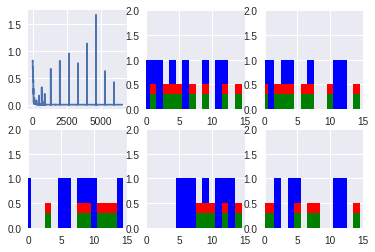

In [19]:
with tf.Session(graph=graph, config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())
    
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    
    loss_list = []
    
    #init the hidden state #TODO why do it on every epoch ???
    _current_state = np.zeros((batch_size, state_size)) 
    
    for epoch in xrange(num_epochs):
        xx, yy = generateData()
        
        for batch in xrange(num_batches):  #iterating our data provider
            start_ind = batch * truncated_backprop_len
            end_ind = start_ind + truncated_backprop_len
            
#             batchX_placeholder = tf.placeholder(dtype=dtype,
#                                         shape=(batch_size, truncated_backprop_len),
#                                         name="batch_x_placeholder")
#     batchY_placeholder = tf.placeholder(dtype=tf.int32,
#                                         shape=(batch_size, truncated_backprop_len),
#                                         name="batch_y_placeholder")
#     init_state = tf.placeholder(dtype=dtype, shape=(batch_size, state_size),
#                                 name="init_state")
            
            batchX = xx[:, start_ind:end_ind]
            batchY = yy[:, start_ind:end_ind]
            
            _total_loss, _train_step, _current_state, _predictions_series = sess.run([
                total_loss, train_step, current_state, predictions_series
            ], feed_dict= {
                batchX_placeholder: batchX,
                batchY_placeholder: batchY,
                init_state: _current_state,
            }) #note that the _current_state gets updated and then feeded back in
            
            loss_list.append(_total_loss)
            
            if batch % 100 == 0:
                print "Step {} Loss {}".format(batch, _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)
                
plt.ioff()
plt.show()

# Ravelling and Reshaping

In [28]:
aa = np.array([[0, 1],
       [2, 3],
       [4, 5]])
aa

array([[0, 1],
       [2, 3],
       [4, 5]])

In [31]:
np.ravel(aa, order='F')

array([0, 2, 4, 1, 3, 5])

In [32]:
np.reshape(aa, (2, 3), order='F')

array([[0, 4, 3],
       [2, 1, 5]])

In [34]:
np.reshape(np.ravel(aa, order='F'), (2, 3))

array([[0, 2, 4],
       [1, 3, 5]])